In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import matplotlib
import h5py

import calculation.MeanFieldv2 as MFv2
import calculation.CurrentMeirv2 as CMv2
import calculation.SusceptibilitySimpv2 as Susceptv2

In [2]:
### Parameters

couplingValue = 0.7


voltageLeftSpace = np.linspace(1e-5, 1.3, 200)
voltageRightSpace = np.linspace(1.25, 1.6, 100)
voltageCenterSpace = np.linspace(1.5, 2.0, 10)
voltageNewSpace = np.unique(np.concatenate((voltageLeftSpace, voltageCenterSpace, voltageRightSpace)))

TNewSpace = np.linspace(1e-5, 0.5, 45)
lambdaSamples = np.array([1.0])

## Initial Conditions
phiConstantInit = 0.5
phiLambdaInit = 0.9

In [3]:
def computeSaddlePoints(lambdaSamples, Tvalue, voltageSpacePlot, pbar=None):
    
    saddle_points = np.zeros(len(voltageSpacePlot), dtype=float)
    lambdaValue = lambdaSamples[0]
    for i in range(len(voltageSpacePlot)):
        voltageValue = voltageSpacePlot[i]
        result = scipy.optimize.root(MFv2.computeMFLambda, phiConstantInit, args=(lambdaValue, voltageValue, Tvalue, MFv2.Impy, couplingValue), method='lm', tol=1e-6)
        saddle_points[i] = result.x[0]
            
        if pbar is not None:
            pbar.update(1)
    
    return saddle_points


phi_voltage_T = np.zeros((len(TNewSpace), len(voltageNewSpace)), dtype=float)
pbar = tqdm(total=len(TNewSpace)*len(voltageNewSpace), desc='Computing phi(T)')

for i in range(len(TNewSpace)):
    Tvalue = TNewSpace[i]
    phi_voltage_T[i,:] = computeSaddlePoints(lambdaSamples, Tvalue, voltageNewSpace, pbar=pbar)
pbar.close()



Computing phi(T):   0%|          | 0/13950 [00:00<?, ?it/s]

Computing phi(T): 100%|██████████| 13950/13950 [06:48<00:00, 34.16it/s]


(45, 310)


Text(0, 0.5, 'phi')

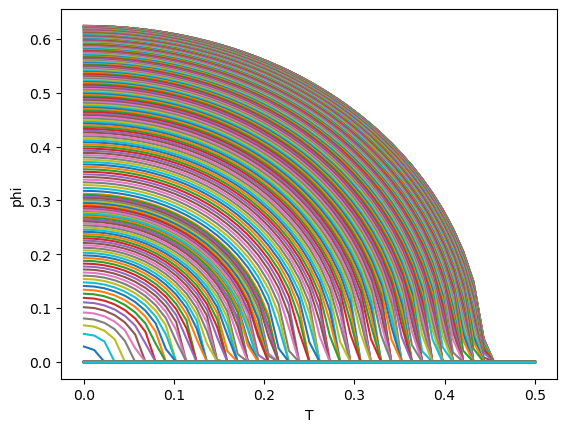

In [4]:
print(phi_voltage_T.shape)

for i in range(phi_voltage_T.shape[1]):
    plt.plot(TNewSpace, phi_voltage_T[:,i])

plt.xlabel("T")
plt.ylabel("phi")

In [5]:

def find_critical_point(x_data, y_data):
    try:
        idx = np.where(y_data > 1e-5)[0]
        x_critical = x_data[idx[-1]+1]
        y_critical = y_data[idx[-1]+1]
    except:
        x_critical = 1e-10
        y_critical = 1e-20
    
    return x_critical, y_critical

T_critical_vec = np.array([find_critical_point(TNewSpace, phi_voltage_T[:, idx])[0] for idx in range(phi_voltage_T.shape[1])])


T_critical_spline = scipy.interpolate.UnivariateSpline(voltageNewSpace, T_critical_vec, s=0.01)
T_critical_spline_vec = np.abs(T_critical_spline(voltageNewSpace))
T_critical_spline_vec[voltageNewSpace > 1.47] = np.nan



In [6]:
print(list(T_critical_spline_vec))

[0.4512648807627112, 0.45122761534437883, 0.4511829594602946, 0.4511308550528203, 0.45107124406431776, 0.45100406843714913, 0.4509292701136759, 0.45084679103625985, 0.450756573147263, 0.450658558389047, 0.4505526887039735, 0.4504389060344047, 0.4503171523227022, 0.45018736951122784, 0.4500494995423431, 0.44990348435841027, 0.449749265901791, 0.44958678611484687, 0.44941598693994, 0.44923681031943213, 0.44904919819568484, 0.4488530925110601, 0.44864843520791986, 0.44843516822862556, 0.44821323351553943, 0.4479825730110229, 0.4477431286574379, 0.4474948423971465, 0.44723765617251016, 0.44697151192589074, 0.4466963515996502, 0.44641211713615025, 0.4461187504777526, 0.4458161935668192, 0.4455043883457119, 0.4451832767567923, 0.4448528007424223, 0.4445129022449638, 0.44416352320677843, 0.4438046055702282, 0.4434360912776748, 0.4430579222714799, 0.44267004049400566, 0.4422723878876137, 0.44186490639466547, 0.4414475379575234, 0.44102022451854883, 0.4405829080201038, 0.44013553040455017, 0.43

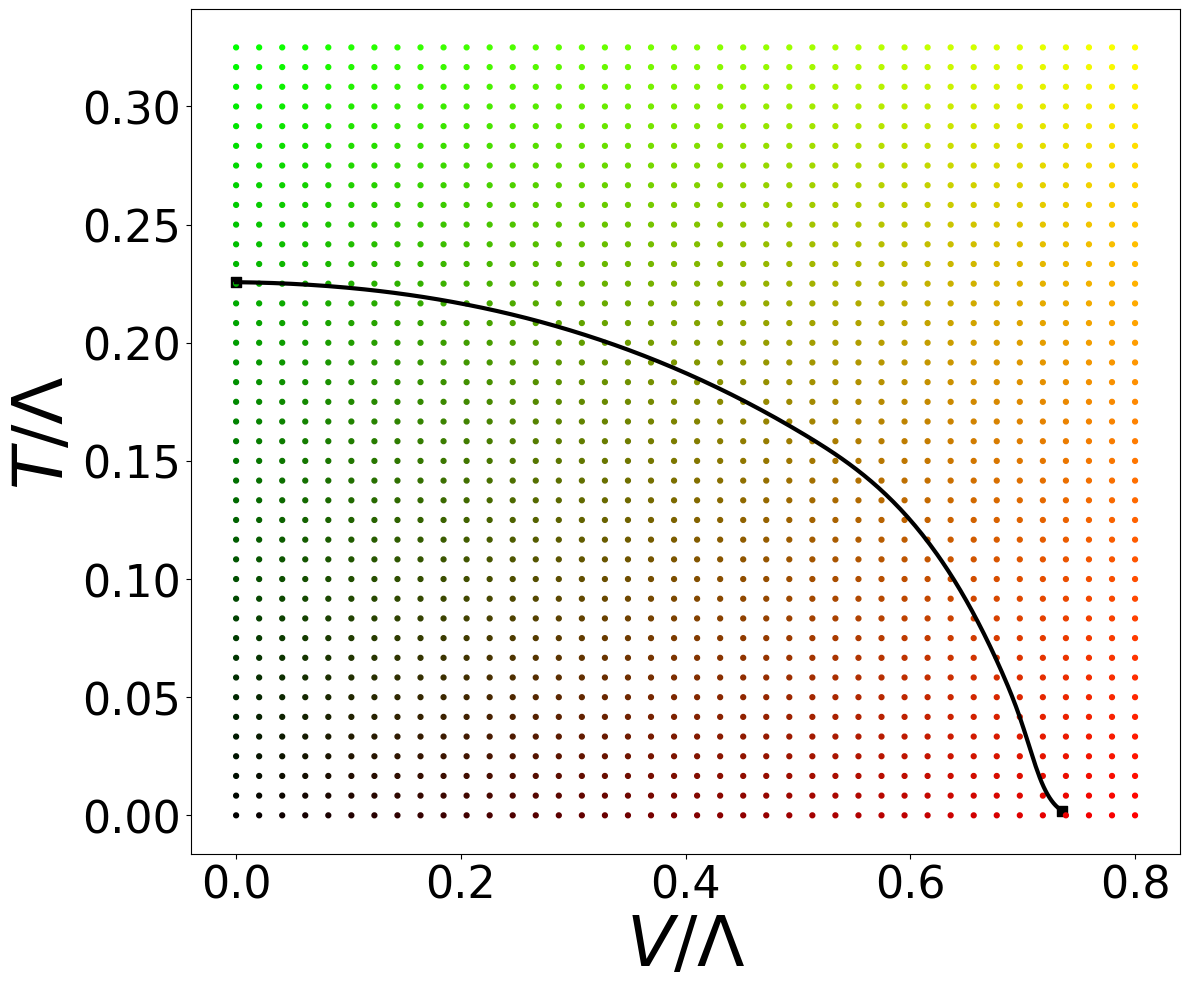

In [7]:

n_points_x = 40
n_points_y = 40

x_min, x_max = 1e-5, 1.6/2
y_min, y_max = 1e-5, 0.65/2


x = np.linspace(x_min, x_max, n_points_x)
y = np.linspace(y_min, y_max, n_points_y)
X, Y = np.meshgrid(x, y)

X_flat = X.flatten()
Y_flat = Y.flatten()

R = (X_flat - x_min) / (x_max - x_min)
G = (Y_flat - y_min) / (y_max - y_min)
B = np.zeros_like(R)

colors = np.stack((R, G, B), axis=1)

fig, ax = plt.subplots(figsize=(12, 10))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
ax.plot(voltageNewSpace/2, T_critical_spline_vec/2, linewidth=3.0, color="black")
ax.scatter(voltageNewSpace[0]/2, T_critical_spline_vec[0]/2, marker="s", color="black", s=60)
ax.scatter(1.47/2, T_critical_spline(1.47)/2, marker="s", color="black", s=60)

ax.scatter(X_flat, Y_flat, color=colors, s=12)

ax.tick_params(axis='y', labelsize=32)
ax.tick_params(axis='x', labelsize=32)

plt.xlabel(r'$V/\Lambda$', fontsize=50)
plt.ylabel(r'$T/\Lambda$', fontsize=50)

plt.tight_layout()
plt.savefig("panels/Transition_TV.png")


In [8]:
print(T_critical_spline_vec[0]/2)

0.2256324403813556


In [9]:

hstep = 1e-5
omegaSpace = np.linspace(-hstep, hstep, 2)

PiR = np.zeros((len(T_critical_vec),len(omegaSpace)), dtype=np.complex128)
PiK = np.zeros((len(T_critical_vec),len(omegaSpace)), dtype=np.complex128)

lambdaValue = lambdaSamples[0]
pbar = tqdm(total=len(voltageNewSpace), desc='Computing PiR and PiK')

for i in range(len(voltageNewSpace)):
   voltageValue = voltageNewSpace[i]
   Tvalue = T_critical_spline_vec[i]
   phiValue = 1e-8
   PiR[i,:] = Susceptv2.computePiR(omegaSpace, lambdaValue, phiValue, voltageValue, couplingValue, Tvalue=Tvalue)
   PiK[i,:] = Susceptv2.computePiKnum(omegaSpace, lambdaValue, phiValue, voltageValue, couplingValue, Tvalue=Tvalue)
      
   pbar.update(1)

pbar.close()


Computing PiR and PiK:  85%|████████▍ | 263/310 [00:15<00:05,  8.70it/s]/Users/joseafonso/Desktop/QP_paper/calculation/SusceptibilitySimpv2.py:72: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrateEpsilonReal = lambda omega: scipy.integrate.quad(PiAtotReal, -const.epsilonDOS, const.epsilonDOS, args=(MFv2.DOS1func, omega), limit=140)[0]
/Users/joseafonso/Desktop/QP_paper/calculation/SusceptibilitySimpv2.py:73: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrateEpsilonImag = lambda omega: scipy.integrate.quad(PiAtotImag, -const.epsilonDOS, const.epsilonDOS, args=(MFv2.DOS1func, omega))[0]
/Users/joseafonso/Desktop/QP_paper/calculation/SusceptibilitySimpv2.py:227: IntegrationWarning: The occurrence of roundoff error is detected, which preve

In [10]:

chiR = PiR/(2.0*lambdaValue**2)
chiK = PiK/(2.0*lambdaValue**2)

FauxPlus = chiR[:,1].imag/chiK[:,1].imag
FauxMinus = chiR[:,0].imag/chiK[:,0].imag

dFaux = (FauxPlus - FauxMinus)/(2*hstep)


In [11]:
print(dFaux)

[1.1079968  1.10807972 1.10815014 1.10822441 1.10829183 1.10835793
 1.10841739 1.10847253 1.10852761 1.10857712 1.10862385 1.10866498
 1.10870847 1.10874457 1.10878154 1.10880854 1.10883933 1.10886946
 1.10889271 1.10891568 1.10893799 1.10895403 1.1089711  1.10898299
 1.10899719 1.1090095  1.10902008 1.10902696 1.10903415 1.10904042
 1.10904343 1.1090507  1.1090461  1.1090509  1.10905316 1.10905221
 1.10905062 1.10904746 1.10904647 1.10903888 1.10903653 1.1090345
 1.10902589 1.10902133 1.10901641 1.10901262 1.10900422 1.10900142
 1.10899378 1.10898319 1.10897813 1.10897549 1.10896414 1.10895795
 1.10894972 1.10893945 1.10893075 1.1089261  1.10891594 1.10890854
 1.10890126 1.10888916 1.10888132 1.10887216 1.1088639  1.10885452
 1.10884469 1.10883349 1.1088212  1.10881073 1.10879996 1.10878764
 1.10877517 1.10876097 1.10874622 1.1087353  1.10872031 1.10870152
 1.10868384 1.10866289 1.10864229 1.10861884 1.10860075 1.1085726
 1.10854916 1.10851786 1.10848944 1.10846006 1.10842396 1.108386

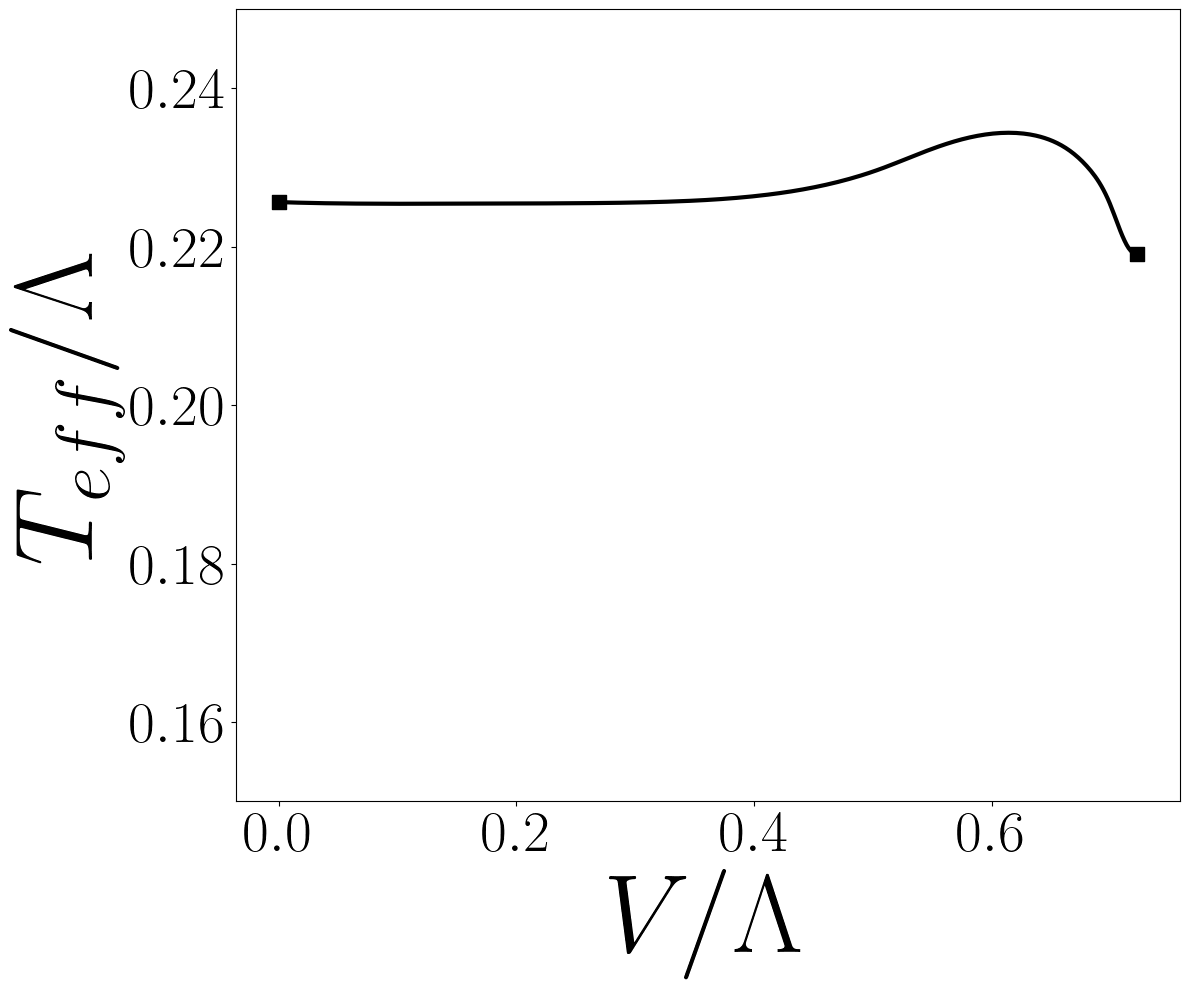

In [15]:
# plt.plot(voltageNewSpace, dFaux)

fig, ax = plt.subplots(figsize=(12, 10))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

ax.plot(voltageNewSpace[:-55]/2, 0.5/dFaux[:-55]/2, linewidth=3.0, color="black")
# plt.ylim(0, 1)
# plt.yscale('log')
# plt.xscale('log')
ax.tick_params(axis='y', labelsize=42)
ax.tick_params(axis='x', labelsize=42)

ax.scatter(voltageNewSpace[0]/2, 0.5/dFaux[0]/2, marker='s', s=100, color="black")
ax.scatter(voltageNewSpace[-55]/2, 0.5/dFaux[-55]/2, marker='s', s=100, color="black")

plt.xlabel(r'$V/\Lambda$', fontsize=80)
plt.ylabel(r'$T_{eff}/\Lambda$', fontsize=80)
plt.ylim(0.15, 0.25)
# plt.xlim(-0.05, 0.8)

plt.tight_layout()
plt.savefig("panels/Teff_Transition_V.png")


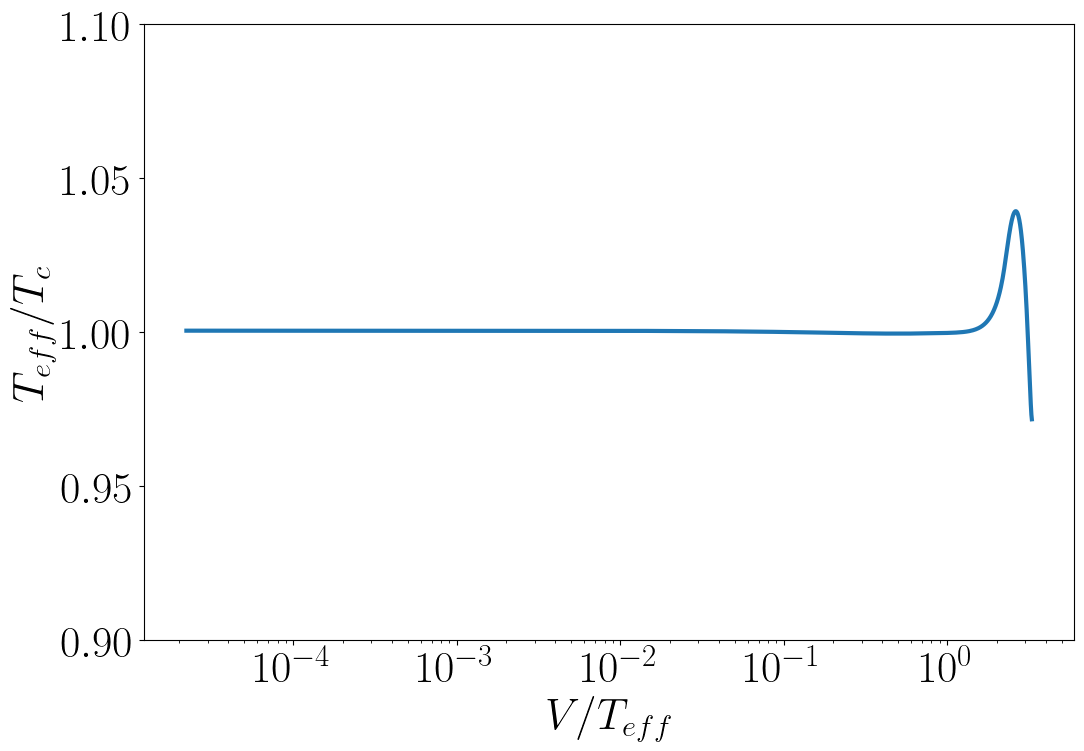

In [13]:
# plt.plot(voltageNewSpace, dFaux)

fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

ax.plot(voltageNewSpace[:-55]/(0.5/dFaux[:-55]), 0.5/dFaux[:-55]/2/0.2255, linewidth=3.0)
# plt.ylim(0, 1)
# plt.yscale('log')
plt.xscale('log')
ax.tick_params(axis='y', labelsize=32)
ax.tick_params(axis='x', labelsize=32)

plt.xlabel(r'$V/T_{eff}$', fontsize=32)
plt.ylabel(r'$T_{eff}/T_c$', fontsize=32)
plt.ylim(0.9, 1.1)

plt.savefig("panels/T_effT_V_Teff.png")